In [114]:
from __future__ import annotations
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 25
})

import torch.optim as optim
import torch.nn as nn
import os
from time import time
from sklearn.datasets import make_moons

# jetnet on base (python 3.7.10)


from jetnet.datasets import JetNet

print(f"Particle features: {JetNet.ALL_PARTICLE_FEATURES}")
print(f"Jet features: {JetNet.ALL_JET_FEATURES}")

import importlib
import simple_diffusion_t_embedding
importlib.reload(simple_diffusion_t_embedding)
from simple_diffusion_t_embedding import *


Particle features: ['etarel', 'phirel', 'ptrel', 'mask']
Jet features: ['type', 'pt', 'eta', 'mass', 'num_particles']


In [61]:
data_args = {
    "jet_type": "g",  # gluon, top quark, and W boson jets
    "data_dir": "datasets/jetnet",
    # only selecting the kinematic features
    "particle_features": ["etarel", "phirel", "ptrel"],
    "num_particles": 30,
    # "jet_features": ["type", "pt", "eta", "mass"],
    "jet_features": ["pt", "eta", "mass"],
    "download": True,
}

particle_data, jet_data = JetNet.getData(**data_args)

In [40]:
print(f'jet_data.shape: {jet_data.shape}')
print(f'particle_data.shape: {particle_data.shape}')

jet_data.shape: (177252, 3)
particle_data.shape: (177252, 30, 3)


In [41]:
print(f"\nJet features of first jet\n{data_args['jet_features']}\n{jet_data[0]}")


Jet features of first jet
['pt', 'eta', 'mass']
[ 1.32753149e+03 -1.22300756e+00  6.83471985e+01]


In [42]:
particle_data

array([[[ 2.28084670e-03,  1.41175208e-03,  1.31414890e-01],
        [ 5.07566088e-04,  7.04002939e-03,  1.21322654e-01],
        [ 1.32932863e-03,  9.65450832e-04,  8.96186754e-02],
        ...,
        [ 7.33533278e-02, -2.92142957e-01,  4.09625284e-03],
        [ 5.95269054e-02,  8.60507935e-02,  3.81787168e-03],
        [ 2.05075461e-02,  1.70451328e-02,  3.74986720e-03]],

       [[-2.01627575e-02,  1.27474815e-02,  2.37833932e-01],
        [-2.47009005e-02, -3.29086334e-02,  6.92795441e-02],
        [-2.26627830e-02,  2.41135465e-04,  6.52075261e-02],
        ...,
        [ 1.32337213e-01,  3.52588706e-02,  9.42472368e-03],
        [ 4.24267314e-02, -2.34916992e-02,  9.11690015e-03],
        [-3.96369211e-02,  3.96285430e-02,  8.45582131e-03]],

       [[-8.04048777e-03, -1.32631930e-02,  1.41778558e-01],
        [-9.24993400e-03, -9.82325617e-03,  1.31018609e-01],
        [-8.73806700e-03, -1.07506095e-02,  1.02754720e-01],
        ...,
        [-1.04562230e-02, -1.36564933e-02,

In [43]:
jet_ind = 0
const_subset = 10

print(
    f"Particle features of the {const_subset} highest pT particles in the {jet_ind}th jet\n{data_args['particle_features']}\n\
{particle_data[jet_ind, :const_subset]}"
)

Particle features of the 10 highest pT particles in the 0th jet
['etarel', 'phirel', 'ptrel']
[[ 0.00228085  0.00141175  0.13141489]
 [ 0.00050757  0.00704003  0.12132265]
 [ 0.00132933  0.00096545  0.08961868]
 [ 0.00298269  0.00322208  0.08173273]
 [ 0.00150318  0.00367195  0.07478397]
 [-0.00449243  0.00203751  0.06690332]
 [ 0.00050759 -0.0029651   0.05080908]
 [ 0.00240625  0.01022051  0.03915299]
 [ 0.00120075  0.01318428  0.03765943]
 [ 0.02260886  0.02261478  0.03223833]]


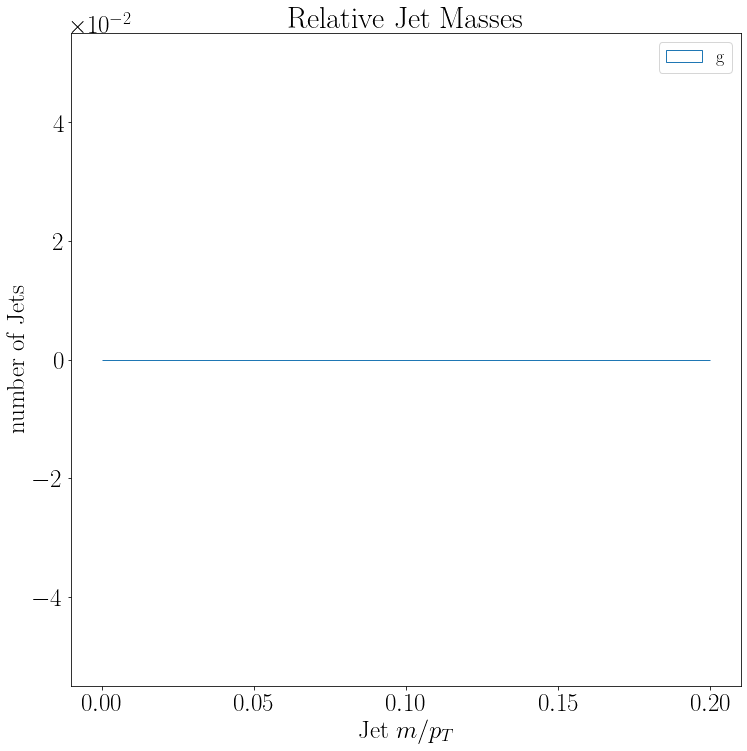

In [45]:
import numpy as np
from jetnet.utils import jet_features

num_types = len(data_args["jet_type"])
# get the index of each jet type using the JetNet.JET_TYPES array
type_indices = {jet_type: JetNet.JET_TYPES.index(jet_type) 
                for jet_type in data_args["jet_type"]}

fig = plt.figure(figsize=(12, 12))
plt.ticklabel_format(axis="y", scilimits=(0, 0), useMathText=True)

# for j in range(num_types):
#     jet_type = data_args["jet_type"][j]
#     type_selector = jet_data[:, 0] == type_indices[jet_type]  # select jets based on jet_type feat

#     jet_masses = jet_features(particle_data[type_selector][:50000])["mass"]
#     _ = plt.hist(jet_masses, bins=np.linspace(0, 0.2, 100), histtype="step", label=jet_type)


jet_masses = jet_features(particle_data[type_selector][:50000])["mass"]
_ = plt.hist(jet_masses, bins=np.linspace(0, 0.2, 100), histtype="step", label=jet_type)


plt.xlabel(r"Jet $m/p_{T}$")
plt.ylabel("number of Jets")
plt.legend(loc=1, prop={"size": 18})
plt.title("Relative Jet Masses")
plt.show()

In [22]:
type_indices

{'g': 0}

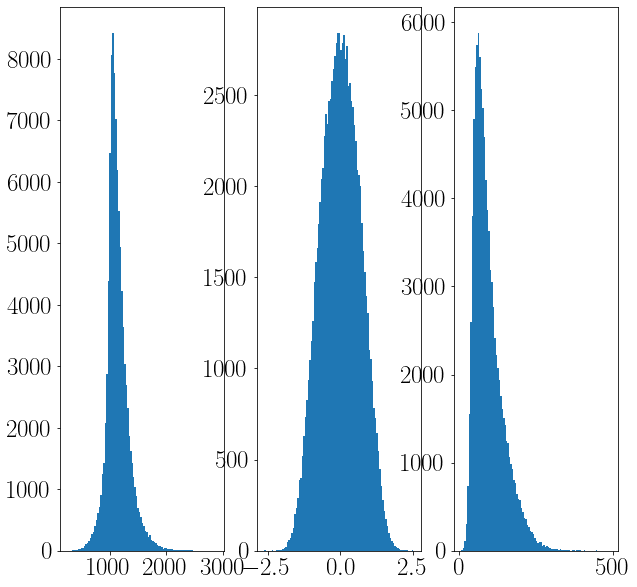

In [101]:
SUBSET = int(1e5)
jet_data_red = jet_data[:SUBSET]
# jet_type = data_args["jet_type"]["mass"]
fig, ax = plt.subplots(1,3, figsize=(10,10))
for i in range(3):
    ax[i].hist(jet_data_red[:,i],bins=100);

## test diffusion model on jet data

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = jet_data_red
x0 = torch.tensor(X, dtype=torch.float32).to(device)
print(f'x0.shape={x0.shape}')


# Total time steps T
T = 1000
# Noise scheduler beta_t, which goes from beta_1 to beta_T
beta_1 = 1e-4
beta_T = 0.02
beta = torch.linspace(beta_1, beta_T, T).to(device)
alpha_ = 1 - beta
alpha_bar = torch.cumprod(alpha_, dim=0)


x0.shape=torch.Size([100000, 3])


t=0
t=200
t=400
t=600
t=800


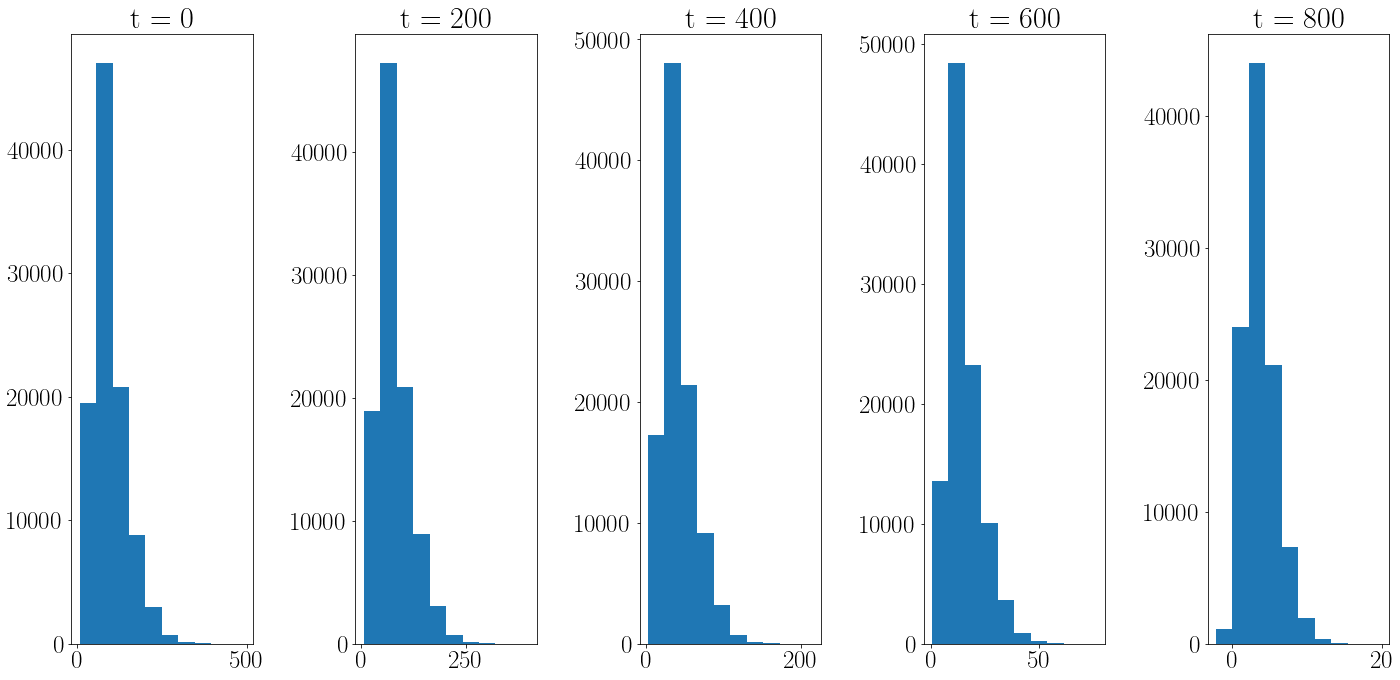

this arbirary function took 0.5622 secs


In [106]:


# Plot the forward diffusion process
plot_forward_xt_jet(T_ex=T, x0=x0.cpu(), alpha_bar=alpha_bar.cpu(), N_plots=5)


In [115]:
# Train the model
epochs = 50
epsilon_theta, x0_mean, x0_std = train(epochs=epochs, 
                      x0=x0, 
                      alpha_bar=alpha_bar, 
                      T=T, 
                      device=device)

Epsilon(
  (time_mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
  )
  (input_layer): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
  )
  (hidden_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
  )
  (output_layer): Linear(in_features=128, out_features=3, bias=True)
)
Epoch 0/50, Loss: 0.298869
Epoch 10/50, Loss: 0.265241
Epoch 20/50, Loss: 0.262883
Epoch 30/50, Loss: 0.267869
Epoch 40/50, Loss: 0.263376
this arbirary function took 119.3918 secs


In [116]:
T_sample_1 = 1000
# calculate time to sample one feature
start_time = time.time()
x_sample_1 = sample_one(
    model=epsilon_theta,
    x0_shape=x0.shape,
    alpha=alpha_,
    beta=beta,
    alpha_bar=alpha_bar,
    T=T_sample_1,
    device=device,
)
x_sample_1 = x_sample_1.numpy()
end_time = time.time()
print(f'Time to sample one feature of shape={x_sample_1.shape}: {end_time - start_time:.2f} seconds')

Time to sample one feature of shape=(100000, 3): 227.88 seconds


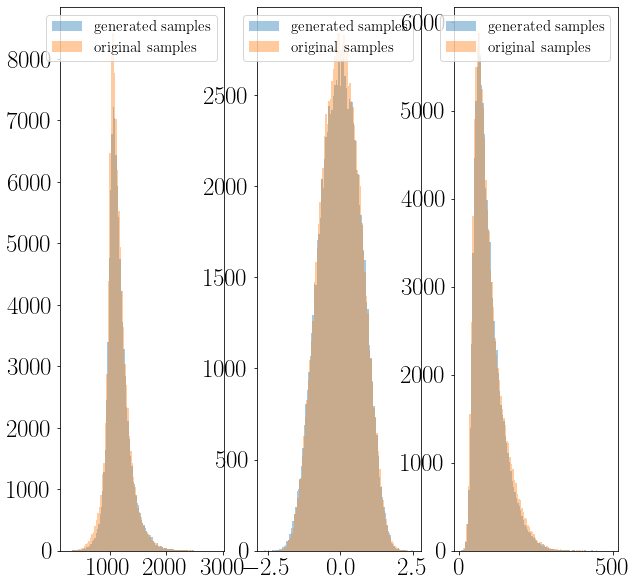

In [121]:
fig, ax = plt.subplots(1,3, figsize=(10,10))

x_sample_1_denormalized = x0_mean.numpy() + x_sample_1 * x0_std.numpy()
for i in range(3):
    ax[i].hist(x_sample_1_denormalized[:,i],bins=100, alpha = 0.4, label = 'generated samples')
    ax[i].hist(X[:,i],                     bins=100, alpha = 0.4, label = 'original samples')
    ax[i].legend(fontsize=15)